# Model Analysis with visualization

In [1]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### File path

In [2]:
test_path = "../data/Test"
input_parameters = "model_parameters_efficientnetb0_224/best_test_acc/model_weights.pth"

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # For Apple Silicon (M1/M2)
else:
    device = torch.device("cpu")


### Load model

In [4]:
from torchvision.models import efficientnet_v2_s, efficientnet_b0
model = torchvision.models.efficientnet_b0(weights=None)

batch_size = 16
img_size = 224 # 224 for efficientnet_b0, 384 for efficientnet_v2_s

### Load test data

In [5]:
# Precomputed mean and std
# for EfficientNetB0 and batch=16
# mean, std = calculate_mean_std()
mean = [0.7505297064781189, 0.5858979821205139, 0.5854080319404602]
std = [0.1179748997092247, 0.14000017940998077, 0.15512846410274506]

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
    ])

test_dataset = datasets.ImageFolder(root=test_path, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
class_counts = [0] * len(test_dataset.classes)
for _, label in test_dataset.samples:
    class_counts[label] += 1

print(f"Total Classes: {len(test_dataset.classes)}")
print(f"Class counts: {class_counts}")
print(f"Classes: {test_dataset.classes}")

Total Classes: 9
Class counts: [16, 16, 16, 16, 16, 16, 3, 16, 3]
Classes: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [7]:
# Precomputed class weights of training set
train_class_weights = [2.1823, 0.6616, 2.6187, 0.5680, 0.6969, 0.5385, 3.2309, 1.3745, 1.7898]
class_weights = torch.tensor(train_class_weights, dtype=torch.float32).to(device)
loss_function = nn.CrossEntropyLoss(weight=class_weights)

### Configure classifier and load weights

In [8]:
num_classes = len(test_dataset.classes)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    
    nn.Linear(num_features, 256),
    nn.BatchNorm1d(256),
    nn.LeakyReLU(),

    nn.Linear(256, num_classes),
)

In [9]:
checkpoint = torch.load(input_parameters, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Evaluation

In [10]:
model = model.to(device)
model.eval()

test_loss = 0.0
correct_test = 0
total_test = 0

arr_predicted = []
arr_labels = []
arr_outputs = []

test_bar = tqdm(test_loader, desc=f"Testing:", leave=False)
with torch.no_grad():
    for images, labels in test_bar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_function(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        # Collect predictions and true labels
        arr_predicted.extend(predicted.cpu().numpy())
        arr_labels.extend(labels.cpu().numpy())
        arr_outputs.extend(F.softmax(outputs, dim=1).cpu().numpy())  # Probabilities for AUC-ROC

        # Update progress bar
        test_bar.set_postfix({
            'loss': f"{test_loss / total_test:.4f}",
            'acc': f"{100. * correct_test / total_test:.2f}%"
        })
    
# Print test loss and accuracy
test_acc = 100. * correct_test / total_test
print(f"Test Loss: {test_loss / total_test:.4f}, Test Acc: {test_acc:.2f}%")

Test Loss: 0.9635, Test Acc: 74.58%


### Model metrics

In [11]:
# Accuracy: The proportion of correctly classified samples.
# Precision: The proportion of true positives out of all predicted positives.
# Recall: The proportion of true positives out of all actual positives.
# F1-Score: The harmonic mean of precision and recall.
# AUC-ROC: Measures the ability of the model to distinguish between classes. 
#          For multi-class, it uses the One-vs-Rest (OvR) strategy.

In [12]:
# Convert to numpy arrays
arr_labels = np.array(arr_labels)
arr_predicted = np.array(arr_predicted)
arr_outputs = np.array(arr_outputs)

# Calculate metrics
accuracy = accuracy_score(arr_labels, arr_predicted)
precision = precision_score(arr_labels, arr_predicted, average='weighted', zero_division=0)
recall = recall_score(arr_labels, arr_predicted, average='weighted', zero_division=0)
f1 = f1_score(arr_labels, arr_predicted, average='weighted')
# AUC-ROC (One-vs-Rest for multi-class)
auc_roc = roc_auc_score(arr_labels, arr_outputs, multi_class='ovr')

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 0.7458
Precision: 0.7740
Recall: 0.7458
F1-Score: 0.7322
AUC-ROC: 0.9551


### Visualization

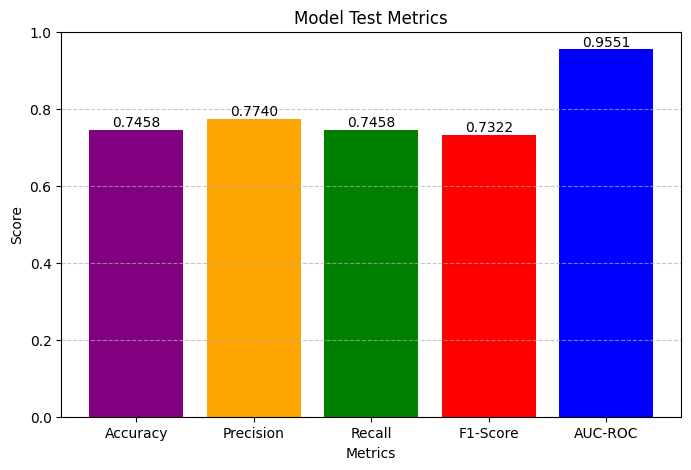

In [13]:
# Metrics
metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "AUC-ROC": auc_roc
}

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics.keys(), metrics.values(), color=['purple', 'orange', 'green', 'red', 'blue'])
plt.ylim(0, 1)  # Metrics are between 0 and 1
plt.title("Model Test Metrics")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with metric values
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        height + 0,                      # Y-coordinate (slightly above the bar)
        f"{height:.4f}",                    # Text to display (formatted to 2 decimal places)
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.show()

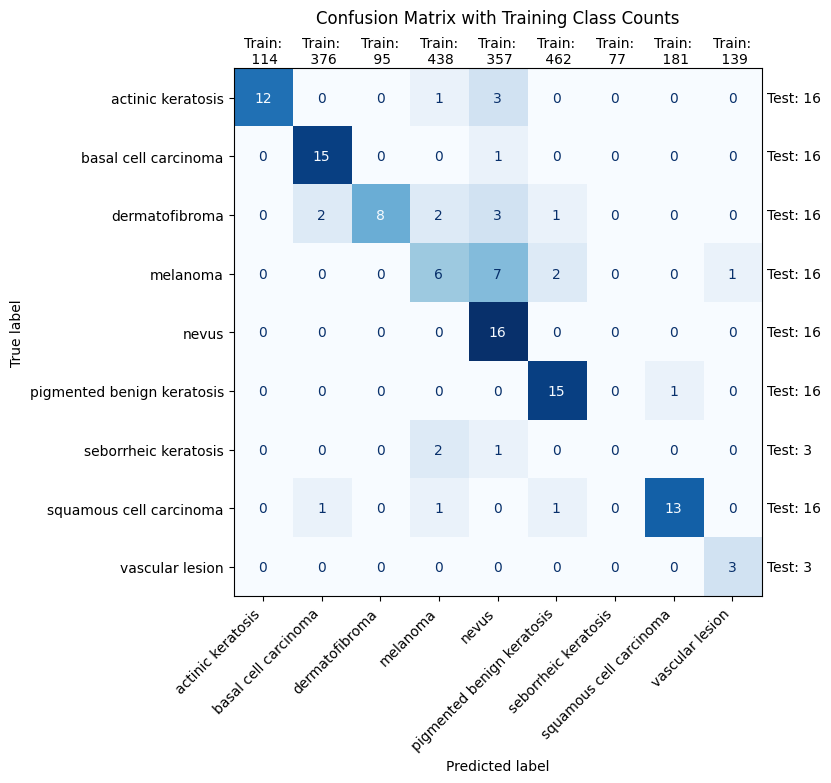

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(arr_labels, arr_predicted)

# Display confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size for better readability
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap=plt.cm.Blues, colorbar=False, ax=ax)

# Add class counts to the plot
train_class = [114, 376, 95, 438, 357, 462, 77, 181, 139]
for i, count in enumerate(train_class):
    plt.text(
        i,
        -0.8,
        f"Train:\n {count}",
        ha='center', va='center', fontsize=10, color='black'
    )

for i, count in enumerate(class_counts):
    plt.text(
        len(test_dataset.classes) - 0.4,
        i,
        f"Test: {count}",
        ha='left', va='center', fontsize=10, color='black',
    )

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add title and adjust layout
plt.title("Confusion Matrix with Class Counts", y=1.07)
plt.tight_layout()
plt.show()